# Tutorial: Audio and Sheet Music Embedding
In this tutorial we show how to apply the embedding networks to both,
- new sheet music as well as
- new audio files.

First we need to import a couple of standard python packages
for loading and visualizing the data.
We require additional imports later on,
but import the packages where they are applied to show how things are related.

In [1]:
from __future__ import print_function

import cv2
import yaml
import numpy as np
import matplotlib.pyplot as plt

# this is the default height of our staff systems
# (it is fixed as we process it with a convolutional neural network)
SYSTEM_HEIGHT = 160

# path to sheet image file
sheet_img_path = "sheet_image.png"
# sheet_img_path = "mozart.png"

# path to audio file
audio_path = "audio.mp3"
# audio_path = "mozart.flac"

## Loading a Sheet Image
Next we load a sheet image an resize it to our target image width of 835 pixels.<br>
We provide a test sheet image in the folder of this tutorial (*sheet_image.png*).

In [2]:
def resize_img(I):
    """
    Resize image to target width of 835 pxls
    """
    width = 835
    scale = float(width) / I.shape[1]
    height = int(scale * I.shape[0])
    I = cv2.resize(I, (width, height))
    return I

In [3]:
# load sheet image
sheet_image = cv2.imread(sheet_img_path, 0)
sheet_image = resize_img(sheet_image)

## Automatic System Detection
The next step is to detect staff systems in the sheet image
in order to be able to unroll the score into one long staff line.
This will make further processing much easier
and we require this anyways to feed the score image into our network.

Along with our project we provide some simple Optical Music Recognition (OMR) Tools.
This is how we import them:

In [4]:
# import omr stuff
from audio_sheet_retrieval.sheet_utils.omr import OpticalMusicRecognizer, prepare_image
from audio_sheet_retrieval.sheet_utils.omr import SegmentationNetwork
from audio_sheet_retrieval.sheet_utils import system_detector, bar_detector

/home/luis/miniconda3/envs/asr/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7402 on context None
Mapped name None to device cuda0: GeForce RTX 2070 (0000:01:00.0)


Having the OMR module imported, we initialize it with the provided pre-trained models:

In [5]:
# initialize system detection
net = system_detector.build_model()
system_net = SegmentationNetwork(net)
system_net.load('../audio_sheet_retrieval/sheet_utils/omr_models/system_params.pkl')

# initialize bar detection
net = bar_detector.build_model()
bar_net = SegmentationNetwork(net)
bar_net.load('../audio_sheet_retrieval/sheet_utils/omr_models/bar_params.pkl')

# initialize OMR system
omr = OpticalMusicRecognizer(note_detector=None, system_detector=system_net, bar_detector=bar_net)

Once the OMR system is initialized system detection should become easy:

In [6]:
# prepare image for processing with network (e.g. conversion to float32)
sheet_image_prep = prepare_image(sheet_image)

# detect systems
page_systems = omr.detect_systems(sheet_image_prep, verbose=False)

Let's visualize the result:

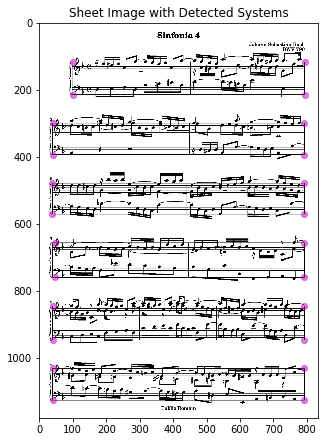

In [7]:
plt.figure("System Localization", figsize=(5, 10))
plt.clf()
plt.imshow(sheet_image, cmap=plt.cm.gray)
plt.xlim([0, sheet_image.shape[1] - 1])
plt.ylim([sheet_image.shape[0] - 1, 0])
for system in page_systems:
    plt.plot(system[:, 1], system[:, 0], 'mo', alpha=0.5)
plt.title("Sheet Image with Detected Systems")
plt.show()

## Unrolling the Score
Given the detected systems the next step is to unroll the score.
Here is how we can do this:

In [8]:
# unwrap sheet given system detections
unwrapped_sheet = np.zeros((SYSTEM_HEIGHT, 0), dtype=np.uint8)
for system in page_systems:

    r0 = int(np.mean([system[0, 0], system[2, 0]])) - SYSTEM_HEIGHT // 2
    r1 = r0 + SYSTEM_HEIGHT
    c0 = int(system[0, 1])
    c1 = int(system[1, 1])

    # fix row slice coordinates
    r0 = max(0, r0)
    r1 = min(r1, sheet_image.shape[0])
    r0 = max(r0, r1 - SYSTEM_HEIGHT)

    staff_img = sheet_image[r0:r1, c0:c1].astype(np.uint8)

    if staff_img.shape[0] < SYSTEM_HEIGHT:
        to_pad = SYSTEM_HEIGHT - staff_img.shape[0]
        if to_pad > (0.1 * SYSTEM_HEIGHT):
            print("Problem in system padding!!!")
            continue
        staff_img = np.pad(staff_img, ((0, to_pad), (0, 0)), mode="edge")

    unwrapped_sheet = np.hstack((unwrapped_sheet, staff_img))

Again, this is what we get as a result:

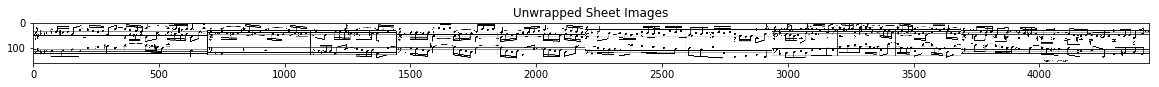

In [9]:
plt.figure("Unwrapped Sheet Image", figsize=(20, 5))
plt.clf()
plt.imshow(unwrapped_sheet, cmap=plt.cm.gray)
plt.title("Unwrapped Sheet Images")
plt.show()

## Sheet Snippet Embedding
To make working with our networks easier,
we wrap all the theano code into one retrieval class (*RetrievalWrapper*).
In addition we also import the definition file of our retrieval model (*mutopia_ccal_cont_rsz*).

In [10]:
# this class contains some convenience code for embedding computation
from audio_sheet_retrieval.retrieval_wrapper import RetrievalWrapper
# this is our retrieval model
from audio_sheet_retrieval.models import mutopia_ccal_cont_rsz_dense_att as model
# this is the configuration file
config_file = "../audio_sheet_retrieval/exp_configs/mutopia_full_aug_sc.yaml"
with open(config_file, 'rb') as hdl:
    config = yaml.load(hdl)

Next we initialize the encoder networks with a set of pre-trained weights.

In [11]:
# path to network parameters
param_file = "params_all_split_mutopia_full_aug_sc.pkl"

# this function is called before a snippet is fed to the network
# (for the present model it resizes the image by a factor of 2)
prepare_sheet_img = model.prepare

# this are dimensions of sheet image snippet and audio excerpt
sheet_shape = [1, config['STAFF_HEIGHT'], config['SHEET_CONTEXT']]
spec_shape = [1, config['SPEC_BINS'], config['SPEC_CONTEXT']]
print("snippet_shape", sheet_shape)
print("excerpt_shape", spec_shape)

# initialize retrieval wrapper
embed_network = RetrievalWrapper(model, spec_shape, sheet_shape, param_file, prepare_view_1=prepare_sheet_img, prepare_view_2=None)

snippet_shape [1, 160, 200]
excerpt_shape [1, 92, 42]
Building network ...
Loading model parameters from: params_all_split_mutopia_full_aug_sc.pkl
Compiling prediction functions ...


Then we slice the unrolled sheet image into 100 small snippets.

In [12]:
# slice central part of unrolled sheet
r0 = unwrapped_sheet.shape[0] // 2 - sheet_shape[1] // 2
r1 = r0 + sheet_shape[1]

In [13]:
# equally sample 100 snippets
n_samples = 100
start_indices = np.linspace(start=0, stop=unwrapped_sheet.shape[1]-sheet_shape[2], num=n_samples)
start_indices = start_indices.astype(np.int)

In [14]:
# collect sheet snippets
sheet_snippets = np.zeros((len(start_indices), 1, sheet_shape[1], sheet_shape[2]), dtype=np.float32)
for i, idx in enumerate(start_indices):
    sheet_snippets[i, 0] = unwrapped_sheet[r0:r1, idx:idx+sheet_shape[2]]

print("Sheet snippet shape", sheet_snippets.shape)

Sheet snippet shape (100, 1, 160, 200)


Finally, we feed the sheet snippets through the image part of the encoding network
and end up with 100 32-dimensional vectors.

In [15]:
# compute sheet snippet codes
sheet_codes = embed_network.compute_view_1(sheet_snippets)
print("Sheet code shape", sheet_codes.shape)

Sheet code shape (100, 32)


## Audio Excerpt Embedding
Above we have shown how to compute image embeddings starting from an entire score image.
In this part of the notebook we explain with its counterpart, an music audio.

The first thing we need to do is to compute a spectrogram from the audio file.

In [16]:
# this is what we need to import from the madmom project
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.filters import LogarithmicFilterbank
from madmom.audio.spectrogram import FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor
from madmom.processors import SequentialProcessor

# init signal processing as described in the paper
SAMPLE_RATE = 22050
FRAME_SIZE = 2048
FPS = 20

sig_proc = SignalProcessor(num_channels=1, sample_rate=SAMPLE_RATE)
fsig_proc = FramedSignalProcessor(frame_size=FRAME_SIZE, fps=FPS, origin='future')
spec_proc = FilteredSpectrogramProcessor(LogarithmicFilterbank, num_bands=16, fmin=30, fmax=6000)  # num_bands=24, fmin=30, fmax=8000
log_spec_proc = LogarithmicSpectrogramProcessor()
processor = SequentialProcessor([sig_proc, fsig_proc, spec_proc, log_spec_proc])

# compute spectrogram
spectrogram = processor.process(audio_path).T

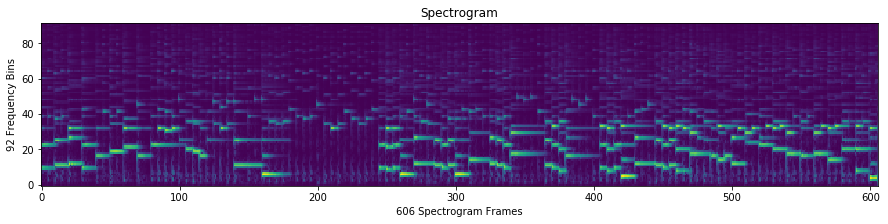

In [17]:
plt.figure("Spectrogram", figsize=(15, 3))
plt.clf()
plt.imshow(spectrogram, cmap="viridis", aspect="auto", origin="lower")
plt.title("Spectrogram")
plt.ylabel("%d Frequency Bins" % spectrogram.shape[0])
plt.xlabel("%d Spectrogram Frames" % spectrogram.shape[1])
plt.show()

Given this spectrogram we proceed as with the unrolled sheet image
by slicing it into 100 small excerpts.

In [18]:
n_samples = 100
start_indices = np.linspace(start=0, stop=spectrogram.shape[1]-spec_shape[2], num=n_samples)
start_indices = start_indices.astype(np.int)

# collect spectrogram excerpts
spec_excerpts = np.zeros((len(start_indices), 1, spec_shape[1], spec_shape[2]), dtype=np.float32)
for i, idx in enumerate(start_indices):
    spec_excerpts[i, 0] = spectrogram[:, idx:idx+spec_shape[2]]

print("Spectrogram excerpt shape", spec_excerpts.shape)

Spectrogram excerpt shape (100, 1, 92, 42)


The last thing to do is to feed the spectrogram excerpts through the audio part of the encoding network
to again end up with 100 32-dimensional vectors.

In [19]:
# compute spectrogram codes
spec_codes = embed_network.compute_view_2(spec_excerpts)
print("Spectrogram code shape", spec_codes.shape)

Spectrogram code shape (100, 32)


## Toy Application: Embedding Space Distance
To see if everything worked out we simply compute the pairwise distance between sheet image snippets and audio excerpts in embedding space.
The image of the distance matrix below should contain a dark diagonal line of very small distances.
This could be for example the input to a nearest neighbor search or Dynamic Time Warping (DTW) in the case of alignment.

In [20]:
from sklearn.metrics.pairwise import pairwise_distances
dists = pairwise_distances(sheet_codes, spec_codes)

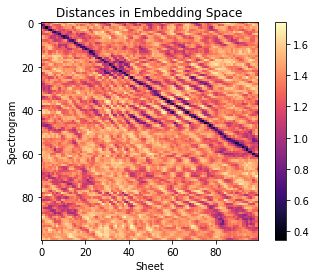

In [21]:
plt.figure("Distances")
plt.clf()
plt.imshow(dists, cmap="magma", interpolation="nearest")
plt.title("Distances in Embedding Space")
plt.xlabel("Sheet")
plt.ylabel("Spectrogram")
plt.colorbar()
plt.show()